In [101]:
# 베이스 추정에 의한 회귀 분석
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [102]:
#파라미터 설정
beta_true = 1.0 / (0.3) ** 2
alpha = 1.0 / 100 ** 2
M = 9  # 다항식 차수
N_list = [4, 5, 10, 100]
beta = beta_true

In [103]:
# 트레이닝 셋 {x_n,y_n} (n=1...N) 을 준비
def generate_training_set(num):
    dataset = pd.DataFrame(columns=["x", "y"])
    for idx in range(num):
        x = float(idx) / float(num - 1)
        y = np.sin(2.0 * np.pi * x) + np.random.normal(scale=0.3)
        dataset = dataset.append(pd.Series([x, y], index=["x", "y"]),
                                 ignore_index=True)
    return dataset

In [104]:
m = 9
N = 5
idx = 0
training_set = generate_training_set(N)
t = training_set.y

# iteration index: c
c = 0

print(training_set)

      x         y
0  0.00  0.392885
1  0.25  0.836712
2  0.50 -0.625742
3  0.75 -0.985448
4  1.00  0.271144


In [105]:
def calc_phi(dataset):
    phis = pd.DataFrame() # (size=(N,M+1))
    for i in range(0, m + 1):
        p = dataset.x ** i
        p.name = "x**%d" % i
        phis = pd.concat([phis, p], axis=1)
    return phis

In [106]:
def calc_s(phis):
    # 분산(S) 계산
    phiphi_sum = 0
    for _, phi in phis.iterrows():
        phi = phi.values[:,np.newaxis] # reshape the phi (M+1,) to (M+1,1)
        phiphi_sum += np.dot(phi,phi.T) # (size=(M+1,M+1))
    s_inv = alpha * pd.DataFrame(np.identity(m + 1)) + beta * phiphi_sum
    s = np.linalg.inv(s_inv)  # 사후분포의 공분산행렬
    return s

In [111]:
#phis (size=(5,10))
#tn (size = (5,)
# phis.iloc[0]*t.iloc[0]
phis = calc_phi(training_set)
w_mean = (phis*t[:,np.newaxis]).sum(axis=0).values
s = calc_s(phis)
df_p_w_t = pd.DataFrame({"w": w_mean, "s": s.diagonal()})
df_p_w_t

<ipython-input-111-77a116b7478d>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  w_mean = (phis*t[:,np.newaxis]).sum(axis=0).values


,w,s
0,-0.110450,0.089846
1,-0.571635,58.429365
2,-0.387312,2062.993418
3,-0.209736,6561.327879
4,-0.076499,6464.450772
5,0.018555,6991.624473
6,0.086182,7940.739988
7,0.134765,8003.642569
8,0.170056,6949.395356
9,0.195933,5163.510856


<ipython-input-112-8476f941923c>:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(variance).diagonal()
<ipython-input-112-8476f941923c>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-112-8476f941923c>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-112-8476f941923c>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-112-8476f941923c>:26: FutureWarn

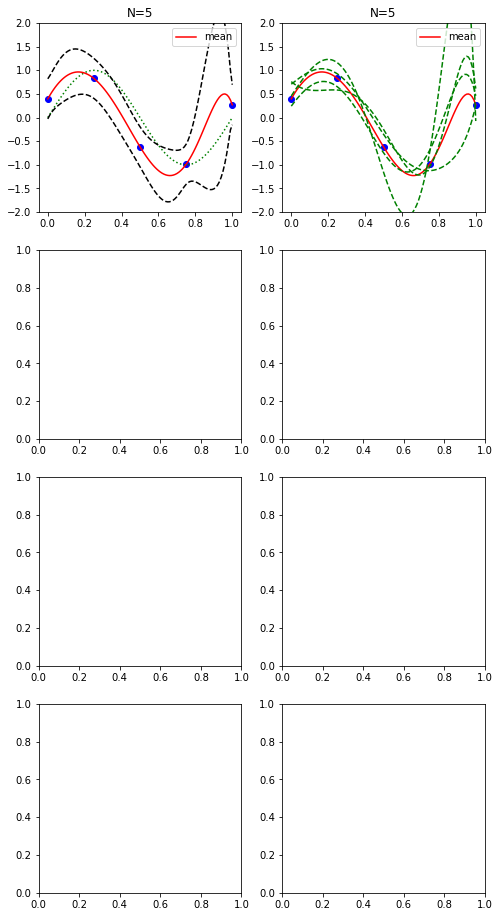

In [112]:
# 평균 m(x)
# phi.T: (size=(1,M+1))
# S: (size=(M+1,M+1))
# sigma_t_phi: (size=(M+1,1))
def mean_fun(x):
    t = training_set.y
    phi_x = np.array([x ** i for i in range(0, m + 1)])
    sigma_t_phi= np.sum(np.multiply(t.values[:,np.newaxis],phis.values),axis = 0)
    #TODO flatten지웠는데 괜찮을까?
    # m_x = np.linalg.multi_dot([beta*phi_x.T, s, sum]).flatten()
    m_x = np.linalg.multi_dot([beta*phi_x.T, s, sigma_t_phi]).flatten()
    return m_x

# TODO: 분산이 계산된거니 표준편차로 바꿔서 대입시키기
def deviation_fun(x):
    phi_x = pd.DataFrame([x ** i for i in range(0, m + 1)])
    variance = 1.0 / beta + np.linalg.multi_dot([phi_x.T, s, phi_x])
    # TODO diagonal()제거 했는데 괜찮을지 확인하기
    # return variance.diagonal()
    return np.sqrt(variance).diagonal()

def f(x,ws):
    # x : (size=(n,1))
    # ws : (size=(M+1))
    x_n = np.array([x ** i for i in range(0, m + 1)])
    return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)



sigma_t_phi= np.sum(np.multiply(t.values[:,np.newaxis],phis.values),axis = 0)
mean = np.linalg.multi_dot([beta*s,sigma_t_phi])

# Main
fig, axs = plt.subplots(len(N_list),2, figsize=(8,len(N_list)*4))
c = 0

df_ws = pd.DataFrame()
ws_samples = pd.DataFrame(np.random.multivariate_normal(mean,s,4))

# 그래프 이름 및 범위 설정
axs[c][0].set_xlim(-0.05,1.05)
axs[c][0].set_ylim(-2,2)
axs[c][0].set_title("N=%d" % N)
axs[c][1].set_xlim(-0.05,1.05)
axs[c][1].set_ylim(-2,2)
axs[c][1].set_title("N=%d" % N)

# 트레이닝 셋 표시
axs[c][0].scatter(training_set.x, training_set.y, marker='o', color='blue')
axs[c][1].scatter(training_set.x, training_set.y, marker='o', color='blue')

line_x = np.arange(0, 1.01, 0.01)

# 실제 값 계산
line_y_true = np.sin(2 * np.pi * line_x)

# 평균과 표준편차 곡선 계산
line_y_mu = np.array(mean_fun(line_x))
line_y_d = np.array(deviation_fun(line_x))

# 실제값 표시
axs[c][0].plot(line_x, line_y_true, color='green', linestyle=':')

# 평균과 표준편차 곡선 표시
axs[c][0].plot(line_x, line_y_mu, color='red', label='mean')
axs[c][0].legend(loc=1)
axs[c][0].plot(line_x, line_y_mu - line_y_d, color='black', linestyle='--')
axs[c][0].plot(line_x, line_y_mu + line_y_d, color='black', linestyle='--')

# 평균 곡선 표시
axs[c][1].plot(line_x, line_y_mu, color='red', label="mean")
axs[c][1].legend(loc=1)

for index, ws in ws_samples.iterrows():
    line_y_f = f(line_x, ws)
    axs[c][1].plot(line_x, line_y_f, color='green', linestyle='--')
fig.show()
